# Investigate correlations between raw and residual-adjusted values for methylation

In [1]:
library(CpGWAS)
library(pgenlibr)
library(bsseq)
library(data.table)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loa

In [2]:
pvar_path <- "/Users/michaelnagle/code/mwas/gwas/libd_chr1.pvar"
pgen_path <- snp_data_path <- "/Users/michaelnagle/code/mwas/gwas/libd_chr1.pgen"

In [3]:
methylation_data_path <- "/Users/michaelnagle/code/mwas/pheno/dlpfc/out/chr1_AA.rda"

In [4]:
load(methylation_data_path)

## Load and organize data

In [5]:
# Processing methylation data from BSseq object
methylations <- t(as.matrix(getMeth(BSobj2, type = "smooth", what = "perBase")))
colnames(methylations) <- paste0("pos_",
                                 GenomicRanges::start(
                                   GenomicRanges::ranges(
                                     SummarizedExperiment::rowRanges(BSobj2))))

# Read SNP data using pgenlibr with error handling
scaffold_name <- tools::file_path_sans_ext(basename(snp_data_path))
pgen_path <- gsub(snp_data_path, pattern = "pvar", replacement = "pgen")
pvar_path <- gsub(snp_data_path, pattern = "pgen", replacement = "pvar")
psam_path <- gsub(pvar_path, pattern = "pvar", replacement = "psam")

if (!file.exists(pgen_path) || !file.exists(pvar_path) || !file.exists(psam_path)) {
  stop("One or more SNP data files not found at the specified paths.")
}

pvar.1 <- pgenlibr::NewPvar(pvar_path)
pvar.2 <- fread(pvar_path)
pgen <- pgenlibr::NewPgen(pgen_path, pvar = pvar.1)
psam <- fread(psam_path)
psam_in_wgbs <- psam[which(psam$`#IID` %in% rownames(methylations))]
genotype_IDs <- psam_in_wgbs$`#IID`
genotype_IDs <- intersect(rownames(methylations), genotype_IDs)
genotype_IDs <- genotype_IDs[order(genotype_IDs)]

In [6]:
processCovariates <- function(dataFrame,
                              colsToExclude = c("ID.", "DNum", "BrNum",
                                                "brnum", "brnumerical"),
                              genotype_IDs = NULL) {

  if(is.null(genotype_IDs)){
    stop(paste0("`processCovariates must receive a vector of genotype IDs",
                " with order matching methylation trait file."))
  }

  # Sanity check: ensure rownames match brnum
  if (!all(rownames(dataFrame) == dataFrame$brnum)) {
    stop("Row names do not match 'brnum'")
  }

  # Exclude specific columns
  dataFrame <- dataFrame[, !(names(dataFrame) %in% colsToExclude)]

  # Exclude columns with only one factor level and print a warning
  single_factor <- sapply(dataFrame, function(x) length(levels(factor(x))) == 1)

  if (any(single_factor)) {
    # warning("Removing columns with only one factor level: ",
    #         paste(names(dataFrame)[single_factor], collapse = ", "))
    dataFrame <- dataFrame[, !single_factor]
  }

  dataFrame <- dataFrame[which(rownames(dataFrame) %in% genotype_IDs), ]
  dataFrame <- dataFrame[order(rownames(dataFrame)),]

  if(!all(rownames(dataFrame) == genotype_IDs)){
    stop("Mismatch with covariate data and genotype IDs")
  }

  # Get the indices of the factor columns
  factor_columns <- sapply(dataFrame, is.factor)

  # One-hot encode the factor columns using model.matrix
  one_hot_encoded <- model.matrix(~., data = dataFrame[, factor_columns])

  # Combine the one-hot encoded columns with the numeric columns
  final_data <- as.matrix(cbind(one_hot_encoded, dataFrame[, !factor_columns]))

  return(final_data)
}

In [7]:
cov <- processCovariates(dataFrame = colData(BSobj2),
                         colsToExclude = c("ID.", "DNum", "brnum",
                                           "BrNum", "brnumerical"),
                         genotype_IDs = genotype_IDs)

In [8]:
head(cov)

,(Intercept),sexM,primarydxSchizo,agedeath,pmi
Br1003,1,0,0,52.57,26.0
Br1004,1,1,0,21.01,28.5
Br1007,1,1,0,57.10,25.0
Br1017,1,0,0,48.42,23.5
Br1021,1,1,1,63.18,56.5
Br1030,1,0,1,49.65,14.5


## Remove the one methylation sample for which we don't have SNP data (???)

Which one is it?

In [9]:
`%!in%` = Negate(`%in%`)

In [10]:
methylations[1:10, 1:10]

,pos_792731,pos_792910,pos_792972,pos_793022,pos_793225,pos_793543,pos_793635,pos_793771,pos_793919,pos_793959
Br1003,0.9087932,0.8996200,0.8967687,0.8942966,0.8817177,0.8542957,0.8448465,0.8299662,0.8130248,0.8084048
Br1004,0.9223947,0.9280760,0.9292266,0.9299634,0.9317422,0.9315120,0.9309391,0.9297935,0.9282514,0.9277993
Br1007,0.9449515,0.9490644,0.9496138,0.9498514,0.9495221,0.9456745,0.9439775,0.9411216,0.9376951,0.9367393
Br1017,0.8935951,0.8972131,0.8974600,0.8974198,0.8957747,0.8894978,0.8871005,0.8832873,0.8789963,0.8778488
Br1021,0.9423477,0.9446741,0.9447732,0.9446568,0.9428178,0.9362295,0.9336396,0.9293900,0.9243735,0.9229809
Br1030,0.9737736,0.9691090,0.9683158,0.9682230,0.9680183,0.9642738,0.9625017,0.9593694,0.9553385,0.9541536
Br1039,0.8744805,0.8624045,0.8601009,0.8584889,0.8524789,0.8452023,0.8436814,0.8419795,0.8409232,0.8407878
Br1053,0.9096020,0.9136133,0.9140728,0.9141384,0.9121080,0.9027904,0.8989732,0.8926372,0.8850834,0.8829758
Br1054,0.8932799,0.9021580,0.9042581,0.9057988,0.9114384,0.9186939,0.9205190,0.9230448,0.9256031,0.9262666
Br1056,0.9327263,0.9370329,0.9378120,0.9382326,0.9384453,0.9347863,0.9329714,0.9297648,0.9256667,0.9244683


In [11]:
length(rownames(methylations))

[1] 112

In [12]:
setdiff(rownames(methylations), genotype_IDs)

[1] "Br1442"

In [14]:
methylations <- methylations[which(rownames(methylations) %in% genotype_IDs), ]

## Regress methylation data over covariates and collect residuals

As a sanity test, let's do this with base R `lm` to make sure there's nothing wrong with our code and we get the same result.

To save time for this test, select subset of data.

In [15]:
dim(methylations)

[1]     111 2202819

In [18]:
set.seed(42)
methylations_filtered <- methylations[, sample(ncol(methylations), 1000)]

In [19]:
regress_out_cov <- function(methylations, cov, n_benchmarks = NULL) {
  print("We just entered regress_out_cov()")

  if(is.null(methylations)){
    stop("Error: methylation data not found")
  }

  cat("Dimensions of methylations: ", dim(methylations), "\n")

  # Creating the model formula
  colnames(cov) <- gsub("\\(Intercept\\)", "Intercept", colnames(cov))
  cov <- as.data.frame(cov)
  model_formula <- as.formula(paste("y ~ ", paste(colnames(cov), collapse=" + ")))

  n_tests <- if (is.null(n_benchmarks)) ncol(methylations) else n_benchmarks
  residuals_matrix <- matrix(NA, nrow = nrow(methylations), ncol = n_tests)

  for(i in 1:n_tests) {
    y <- methylations[, i]
    lm_model <- lm(model_formula, data = cbind(y, cov))
    residuals_matrix[, i] <- residuals(lm_model)
  }

  cat("Residuals computed for ", n_tests, " tests.\n")
  return(residuals_matrix)
}

In [20]:
methylations_filtered_resid <- regress_out_cov(methylations_filtered,
                                               cov)

[1] "We just entered regress_out_cov()"
Dimensions of methylations:  111 1000 
Residuals computed for  1000  tests.


In [37]:
# Convert matrices to vectors
vector1 <- as.vector(methylations_filtered)
vector2 <- as.vector(methylations_filtered_resid)

# Create a data frame for plotting
combined_data <- data.frame(matrix1_values = vector1, 
                            matrix2_values = vector2)

# Use ggplot2 for scatterplot with regression line
library(ggplot2)

plot <- ggplot(combined_data, aes(x = matrix1_values, y = matrix2_values)) +
  geom_point(alpha = 0.2) +  # Adjust alpha for visibility if many points
  geom_smooth(method = "lm", color = "blue") +  # Regression line
  theme_minimal() +
theme(text = element_text(size = 20),  # Increase general text size
        axis.title = element_text(size = 22),  # Increase axis title size
        plot.title = element_text(size = 24, hjust = 0.5)) +  # Increase plot title size and center it
  labs(x = "Before", y = "After", 
       title = "Methylation matrix before and after\nregressing out covariates")

In [38]:
r_squared <- cor(combined_data$matrix1_values,combined_data$matrix2_values)^2

plot <- plot + annotate("text", x = Inf, y = Inf, hjust = 1.1, vjust = 1.1, 
                        label = paste("R² =", round(r_squared, 3)), size = 7)

`geom_smooth()` using formula = 'y ~ x'


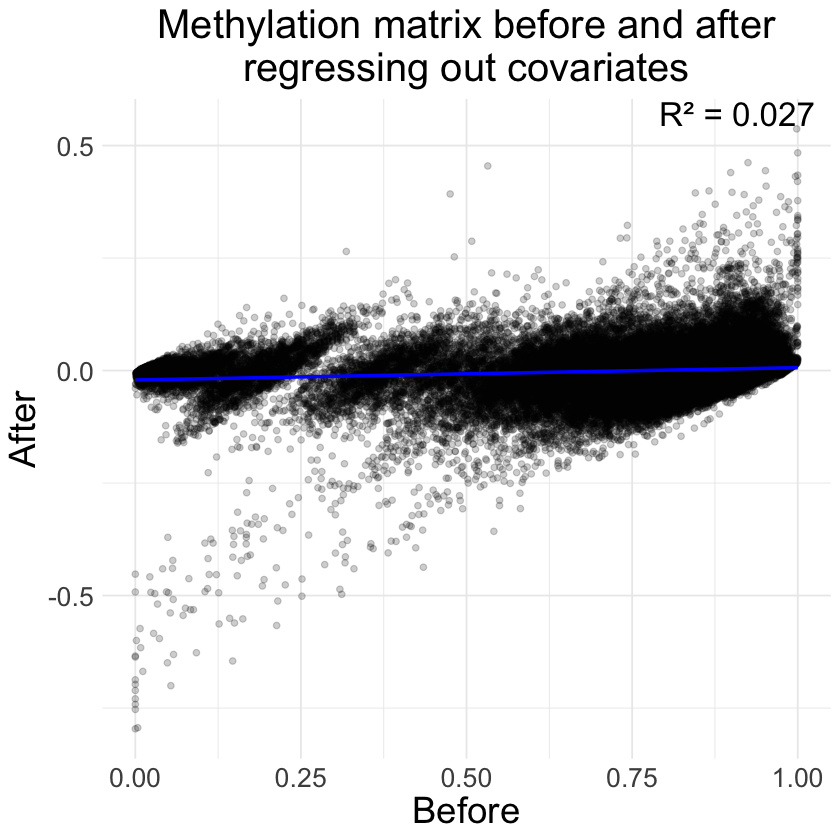

In [39]:
plot